<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm
from skimage.transform import resize


from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH = "gdrive/My Drive/lung_cancer/"
img_path = PATH+'image/'
label_path = PATH+'mask/'

In [35]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

742
742


In [176]:
# load all data to memory
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path + id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = label_path + id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 742/742 [00:09<00:00, 79.77it/s]


In [0]:
# shuffle images
ind_list = [i for i in range(len(X_train))]
random.shuffle(ind_list)
X_train_shuffled = X_train[ind_list]
Y_train_shuffled = Y_train[ind_list]

_X_train = X_train_shuffled[:int(X_train.shape[0]*0.9)]
_Y_train = Y_train_shuffled[:int(Y_train.shape[0]*0.9)]

_X_val = X_train_shuffled[int(X_train.shape[0]*0.9):]
_Y_val = Y_train_shuffled[int(Y_train.shape[0]*0.9):]

In [14]:
# Define IoU metric
from keras import backend as K
def iou(y_true, y_pred):
    intersection = (y_true[:,:,0]*y_pred[:,:,0]).sum()
    union =y_true[:,:,0].sum() + y_pred[:,:,0].sum() - intersection
    return intersection/union

Using TensorFlow backend.


In [335]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy')

# model.summary()
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
    results = model.fit(_X_train, _Y_train, validation_split=0.1, batch_size=4, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 600 samples, validate on 67 samples
Epoch 1/100
600/600 [==============================] - 5s 8ms/step - loss: 0.0691 - val_loss: 0.0131

Epoch 00001: val_loss improved from inf to 0.01313, saving model to model-dsbowl2020-4.h5
Epoch 2/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0117 - val_loss: 0.0112

Epoch 00002: val_loss improved from 0.01313 to 0.01116, saving model to model-dsbowl2020-4.h5
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0098 - val_loss: 0.0090

Epoch 00003: val_loss improved from 0.01116 to 0.00904, saving model to model-dsbowl2020-4.h5
Epoch 4/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0086 - val_loss: 0.0079

Epoch 00004: val_loss improved from 0.00904 to 0.00786, saving model to model-dsbowl2020-4.h5
Epoch 5/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0075 - val_loss: 0.0081

Epoch 00005: val_loss did not improve from 0.00786
Epoch 6/100
600/600 [=

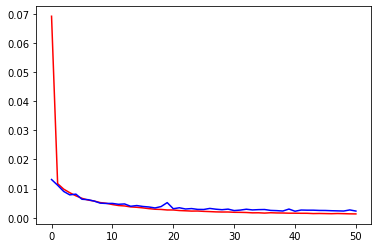

In [336]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epoch = len(loss)
plt.plot(loss, 'r')
plt.plot(val_loss,'b')
plt.show()

75/75 [==============================] - 0s 3ms/step


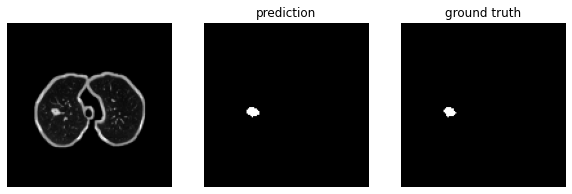

iou :  0.8596491228070176


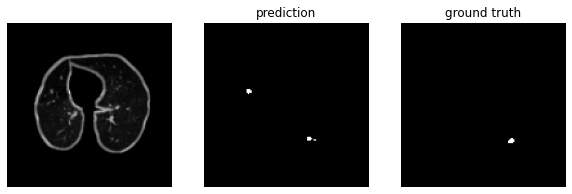

iou :  0.05405405405405406


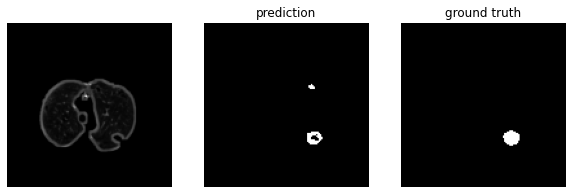

iou :  0.6124031007751938


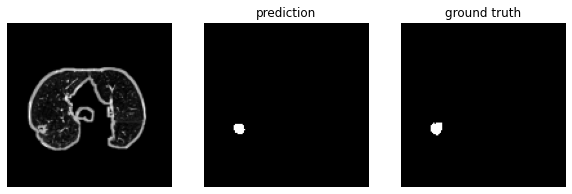

iou :  0.7916666666666666


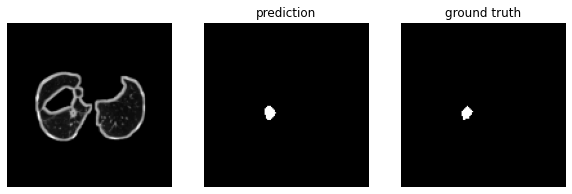

iou :  0.7916666666666666


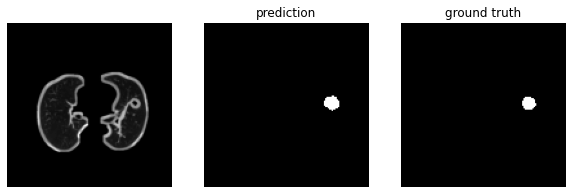

iou :  0.8173076923076923


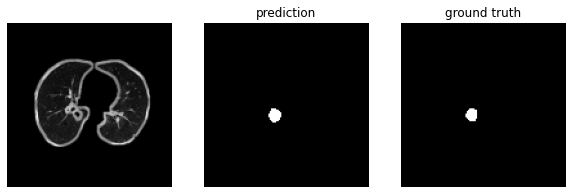

iou :  0.8452380952380952


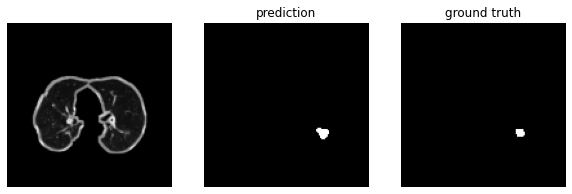

iou :  0.6166666666666667


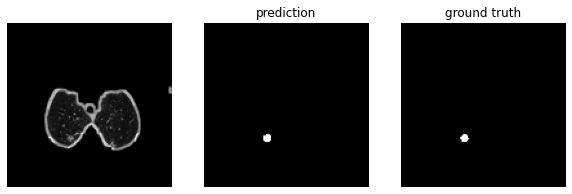

iou :  0.90625


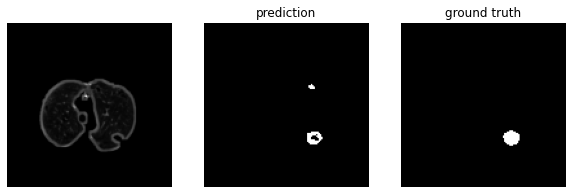

iou :  0.6124031007751938
[0.76666667 0.8        0.66666667 0.68181818 0.90322581 0.63636364
 0.875      0.54545455 0.56521739 0.08737864 0.81818182 0.70212766
 0.81730769 0.86363636 0.         0.72727273 0.875      1.
 0.8        0.63636364 0.62962963 0.66666667 0.71875    0.73684211
 0.85185185 0.58823529 0.89156627 0.28571429 0.79166667 0.85964912
 0.33333333 0.81818182 0.8452381  0.83636364 0.77142857 0.88888889
 0.79166667 0.90625    0.6124031  0.72727273 0.48       0.83673469
 0.05405405 0.875      0.89285714 0.9137931  0.         0.9375
 0.35294118 0.76865672 0.         0.78787879 0.85185185 0.89230769
 0.8        0.81818182 0.         0.79166667 0.84210526 0.
 0.38888889 0.34545455 0.05555556 0.78571429 0.77777778 0.71875
 0.61666667 0.81481481 0.80555556 0.81578947 0.7254902  0.79487179
 0.77777778 0.88235294 0.        ]
0.660270258666029
0.92


In [337]:
# Predict on train, val and test
# model = load_model('model-dsbowl2020-4.h5')
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(_X_val, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

iou_vec = np.array([])
for i in range(10):
    ix = random.randint(0, len(_X_val))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(_X_val[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_val_t[ix][:,:,0]),cmap='gray')
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(_Y_val[ix][:,:,0]),cmap='gray')
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print("iou : ",iou(preds_val_t[ix].astype(np.bool),_Y_val[ix]))

for i in range(len(preds_val_t)):
    iou_vec = np.append(iou_vec, iou(preds_val_t[i].astype(np.bool),_Y_val[i]))
print(iou_vec)
print(iou_vec.mean())
print(np.where(iou_vec>0,1,0).mean())